In [35]:
import os
import glob
import numpy as np
import pandas as pd
from obspy import UTCDateTime, read, Stream
import matplotlib.pyplot as plt

project_dir = '..'
ppick_dir = f'{project_dir}/results/phasenet_diting_others/phasenet_files'
waveform_dir = f'{project_dir}/data/eq_data/2_waveforms'

ppick_file = f'{ppick_dir}/diting_phasenet_pyrocko_3d_grid.csv' 
pyrocko_markers = f'../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt'

print(ppick_dir)
print("marker path", pyrocko_markers)

../results/phasenet_diting_others/phasenet_files
marker path ../results/phasenet_diting_others/00_47_all_picks_PN_PR_DT.txt


Convert PyRocko picks into phasenet format csv file

In [65]:
from my_funcs.my_class_funcs import MyFileConverter
# %reload_ext autoreload

import time
t1 = time.time()

mfc = MyFileConverter()
all_picks_df = mfc.convert_pyrocko_picks_to_phasenet(pyrocko_markers, ppick_file)
print(f"Time taken: {time.time()-t1:.2f} s")

# write to file
all_picks_df.to_csv(f'{ppick_dir}/diting_phasenet_pyrocko_3d_grid.csv', index=False)

Time taken: 1.13 s


In [157]:
# mseed_list = os.listdir(waveform_dir)
mseed_list = pd.read_csv(f'{ppick_dir}/../mseed_list_47.csv').fname.to_list()

# selected event
sel_ev = 'nc73783911.mseed'

# read the ppick file (includes phasenet, diting, pyrocko picks)
pol_df = pd.read_csv(ppick_file, parse_dates=['phase_time', 'pyrocko_phase_time'])

Processing nc73783911.mseed


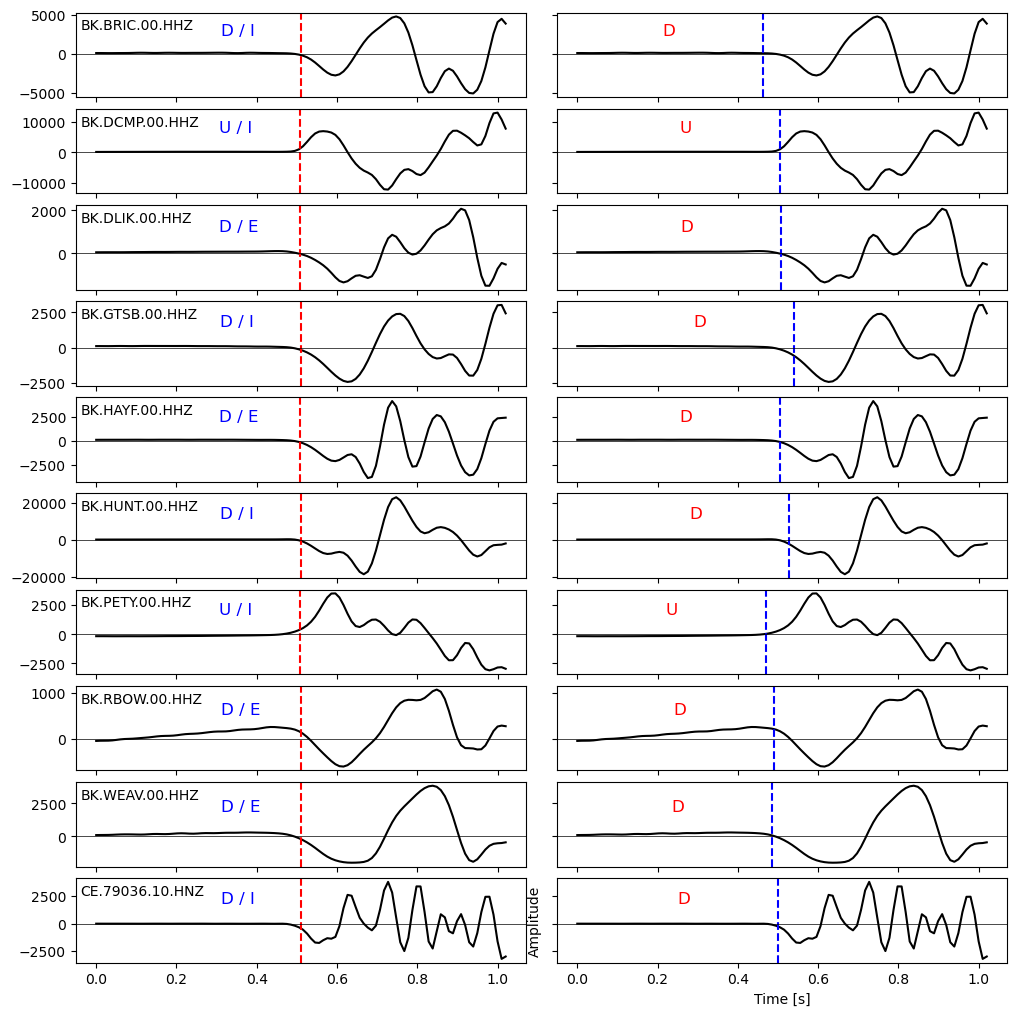

In [182]:
for mseed_file in mseed_list:
    if mseed_file != sel_ev: continue # sel_ev = 'nc73783911.mseed'

    # subset the df for this event only
    event_df = pol_df[pol_df['file_name'] == mseed_file]

    # check if the pyrocko col is empty or not [max should be 1]
    if event_df['pyrocko_polarity'].max() != 1:
        print(f'No pyrocko phase for {mseed_file}')
        continue

    print(f'Processing {mseed_file}')
    ### read the mseed file
    st = read(f'{waveform_dir}/{mseed_file}')

    ### cleanup the dataframe ###
    # drop rows with empty pyrocko phase_time [naT] and empty phasenet phase_time
    event_df = event_df.dropna(subset=['phase_time', 'pyrocko_phase_time']).reset_index(drop=True)

    # drop rows if time difference between phasenet and pyrocko is more than 2 seconds
    event_df['time_diff'] = (event_df['pyrocko_phase_time'] - event_df['phase_time']).dt.total_seconds()
    event_df = event_df[event_df['time_diff'].abs() <= 2].reset_index(drop=True)

    n_subplots = 10 # len(event_df)
    fig, axs = plt.subplots(n_subplots, 2, figsize=(10, 1.*n_subplots))

    for i, row in event_df[0:10].iterrows():

        pn_pick = UTCDateTime(pd.to_datetime(str(row['phase_time'])))
        pr_pick = UTCDateTime(pd.to_datetime(str(row['pyrocko_phase_time'])))
        
        ist = st.select(id=f'{row.station_id}Z')
        tr = ist[0].copy()
        

        # check for empty trace
        if len(tr.data) > 0:
            tr.detrend('demean')
            try:
                tr.detrend('linear')
            except:
                tr.detrend('constant')
            
            try:
                tr.taper(0.001)
                tr.filter('bandpass', freqmin=0.5, freqmax=20, corners=4, zerophase=True)  # Apply a bandpass filter
            except:
                pass
            
            # slice the trace
            sli = 0.5
            # tr2 = tr.copy()
            tr = tr.slice(pn_pick - sli-0.01, pn_pick + sli) # around PhasesNet pick
            # tr2 = tr2.slice(pr_pick - sli-0.01, pr_pick + sli) # around Pyrocko pick [manual polarity]
            
            if not len(tr.data) > 0: # check if the trace is empty
                continue
        
        
            # Generate time axis as a numpy array
            times = np.linspace(0, tr.stats.npts / tr.stats.sampling_rate, tr.stats.npts)

            # get the pick time from starttime into ms
            pn_pick_time = ((pn_pick - tr.stats.starttime) * tr.stats.sampling_rate)/100
            pr_pick_time = ((pr_pick - tr.stats.starttime) * tr.stats.sampling_rate)/100
            
            # get polarity
            dting_pol = row.diting_polarity
            dting_sharp = row.diting_sharpness
            prk_pol = row.pyrocko_polarity
            

            ## plot PhasesNet pick on column 1 ##

            axs[i, 0].plot(times, tr.data, 'k')                                 # plot the waveform
            axs[i, 0].axvline(x=pn_pick_time, color='r', linestyle='--')            # PhasesNet pick
            axs[i, 0].text(
                pn_pick_time-0.2, tr.data.max()*0.5, 
                f"{dting_pol} / {dting_sharp}", 
                fontsize=12, color='b', ha='left')

            # title [station_id] and horizontal line at 0
            axs[i, 0].set_title(
                f"{tr.id}", 
                loc='left', x=0.01,
                y=0.7, fontsize=10
                )
            axs[i, 0].axhline(y=0, color='k', lw=0.5)
            # hide x tick labels for this column except the last one
            if i != n_subplots-1:
                axs[i, 0].set_xticklabels([])
            

            ## plot Pyrocko pick on column 2 ##

            axs[i, 1].plot(times, tr.data, 'k')
            axs[i, 1].axvline(x=pr_pick_time, color='b', linestyle='--')           # Pyrocko pick [manual + phasenet]
            axs[i, 1].text(
                pr_pick_time-0.25, tr.data.max()*0.5,
                f"{'U' if prk_pol == 1 else 'D'}", 
                fontsize=12, color='r',) # polarity

            # title [station_id] and horizontal line at 0
            axs[i, 1].axhline(y=0, color='k', lw=0.5)
            # hide x and y axis tick labels for this column
            axs[i, 1].set_yticklabels([])
            if i != n_subplots-1:
                axs[i, 1].set_xticklabels([])
        
        else:
            continue # mention continue, otherwise it will `pass`
    
    plt.xlabel('Time [s]',)
    plt.ylabel('Amplitude')
    plt.tight_layout( pad=0.1, w_pad=0.1, h_pad=.1)
    plt.show()
            
    break
    